In [1]:
cd ..

/home/scott/Documents/git/bite-me


In [2]:
import sklearn
import pandas as pd
import numpy as np
import datetime

In [3]:
import itertools
import copy

In [4]:
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [5]:
import sklearn.svm
import sklearn.linear_model
import sklearn.cross_validation

In [6]:
import sklearn.decomposition
import sklearn.manifold

In [7]:
import sklearn.ensemble

In [8]:
from eat_it import StratifiedPercentileKFold
from eat_it import scalers
from eat_it import params

In [9]:
import sklearn.metrics

In [10]:
import imp

In [11]:
scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)

In [55]:
def do_cv(cv, clf, X, y, y_transform=None):
    if y_transform is None:
        y_transform = lambda x: x
    scores = []
    all_pred = np.zeros((y.shape))
    for train_index, test_index in cv:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit model
        clf.fit(X_train, y_train)
        # Predict scores for test data
        y_pred = y_transform(clf.predict(X_test))
        # Save all the predictions to an array
        all_pred[test_index] = y_pred
        # Compute mean squared error on this test set
        mse = sklearn.metrics.mean_squared_error(y_transform(y_test),y_pred)
        scores.append(mse)
    # Compute MSE across all samples
    all_score = sklearn.metrics.mean_squared_error(y_transform(y), all_pred)**0.5
    scores = np.asarray(scores)**0.5
    return all_score, scores

In [36]:
def get_cv_results(clf, X, y, n_folds=10, n_samp=25, start_seed=0, y_transform=None):
    all_scores = []
    for seed in range(n_samp):
        cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=start_seed+seed, shuffle_windows=True)
        this_score, _ = do_cv(cv, clf, X=X, y=y, y_transform=y_transform)
        all_scores.append(this_score)
    return np.mean(all_scores), np.std(all_scores)/np.sqrt(n_folds)

def get_mean_cv_score(*args, **kwargs):
    out = get_cv_results(*args, **kwargs)
    return out[0]

In [14]:
### Recursive feature addition
from sklearn.base import clone

def rfa(clf, X, y, n_folds=10, n_samp=25, col_names=None, verbosity=2):
    
    n_features = X.shape[1]
    n_features_to_select = n_features
    step = 1
    
    if col_names is None:
        col_names = range(n_features)
    col_names = np.asarray(col_names)
    
    support_ = np.zeros(n_features, dtype=np.bool)
    ranking_ = n_features * np.ones(n_features, dtype=np.int)
    last_score = None
    
    # Feature addition
    while np.sum(support_) < n_features_to_select:
        # Previously added features
        features_already = np.arange(n_features)[support_]
        # Features to test
        features_to_test = np.arange(n_features)[np.logical_not(support_)]
        
        # Rank the remaining features
        estimator = clone(clf)
        
        #####################################
        # FIT THE CLASSIFIER ON A NESTED FOLD
        #####################################
        
        scores = np.zeros(len(features_to_test))
        for feature_index, test_feature in enumerate(features_to_test):
            features = np.union1d(features_already, [test_feature])
            scores[feature_index] = get_mean_cv_score(estimator, X[:, features], y, n_folds=n_folds, n_samp=n_samp)
            if verbosity>=2:
                print("\tScored %.2f with %s" % (scores[feature_index], ', '.join(col_names[features])))
        
        # Sort the scores in ascending order
        score_order_index = np.argsort(scores)
        ordered_scores   = scores[score_order_index]
        ordered_features = features_to_test[score_order_index]
        
        # Break if no features can improve score
        if last_score is not None and last_score <= ordered_scores[0]:
            if verbosity:
                print('No more improvement possible from {} to {} features'.format(
                        len(features_already),len(features_already)+1))
            break
        
        # Only add `step` many features if it doesn't take us past the target
        n_add = min(step, n_features_to_select - np.sum(support_))
        
        # Only add features which don't make performance go down
        if last_score is not None:
            n_add = min(n_add, len(np.nonzero(ordered_scores < last_score)))
        
        # Select best.
        # We will MINIMISE scoring function!!!
        features_to_add = ordered_features[0:n_add]
        for i in range(n_add):
            if verbosity:
                print('Adding feature {} (scored {})'.format(col_names[ordered_features[i]], ordered_scores[i]))
        
        # Add the features
        support_[features_to_add] = True
        ranking_[features_to_add] = np.sum(support_) + 1 + np.arange(features_to_add)
        
        # Update score monitor
        last_score = ordered_scores[0]
        
    if verbosity:
        print("Best score is {} with features:\n\t{}".format(last_score,', '.join(col_names[support_])))
    
    return support_, ranking_

In [15]:
train = pd.read_csv('data/train.csv', encoding="utf-8")
# Add age in days
end_dt = datetime.datetime.strptime('2015-1-1', "%Y-%m-%d")
train['Age'] = [(end_dt - datetime.datetime.strptime(open_dt, "%m/%d/%Y")).days for open_dt in train['Open Date']]
# add size as boolean field
train['isBig'] = train['City Group']=='Big Cities'
# add each of the big cities as boolean field
train['isIstanbul'] = train['City']=='İstanbul'
train['isAnkara'] = train['City']=='Ankara'
train['isIzmir'] = train['City']=='İzmir'
# add boolean field for type
train['isIL'] = train['Type']=='IL'
# Note when there is the missing 17 fields
train['missingSource'] = train[params.xor_cols].apply(lambda x: np.all(x==0), axis=1)

In [16]:
gtest = pd.read_csv('data/genuinetest.csv', encoding="utf-8")
# Add age in days
end_dt = datetime.datetime.strptime('2015-1-1', "%Y-%m-%d")
gtest['Age'] = [(end_dt - datetime.datetime.strptime(open_dt, "%m/%d/%Y")).days for open_dt in gtest['Open Date']]
# add size as boolean field
gtest['isBig'] = gtest['City Group']=='Big Cities'
# add each of the big cities as boolean field
gtest['isIstanbul'] = gtest['City']=='İstanbul'
gtest['isAnkara'] = gtest['City']=='Ankara'
gtest['isIzmir'] = gtest['City']=='İzmir'
# add boolean field for type
gtest['isIL'] = gtest['Type']=='IL'
# Note when there is the missing 17 fields
gtest['missingSource'] = gtest[params.xor_cols].apply(lambda x: np.all(x==0), axis=1)

In [17]:
# Merge Test and Train together, without having revenue for all entries
unlabelled_data = pd.concat((train, gtest), ignore_index=True)

In [18]:
# Remove DT type from the dataset
unlabelled_data = unlabelled_data[unlabelled_data['Type']!='DT']
unlabelled_data = unlabelled_data[unlabelled_data['Type']!='MB']

In [19]:
# Add known revenues from public test data
gtestrevenue = pd.read_csv('data/genuinetestrevenue.csv', encoding="utf-8")
labelled_test = pd.merge(gtest, gtestrevenue, on='Id')
# Merge all available training data together
data = pd.concat((train, labelled_test), ignore_index=True)

In [20]:
# Remove DT type from the list
data = data[data['Type']!='DT']
data = data[data['Type']!='MB']

In [21]:
# Assemble list of columns
Pcols = ['P'+str(i) for i in range(1,38)]
PMcols = params.xor_cols
PVcols = [i for i in Pcols if i not in params.xor_cols]
Gcols = ['Age']
Ocols = ['isBig','isIstanbul','isAnkara','isIzmir','isIL','missingSource']
cols = Pcols + Gcols + Ocols

In [22]:
# Targets
y = data['revenue'].values

In [23]:
X_indices = data['Id'].values

In [24]:
uX_indices = unlabelled_data['Id'].values

In [25]:
index_is_labelled = [i in X_indices for i in uX_indices]
index_is_labelled = np.asarray(index_is_labelled)

In [26]:
np.array_equal(uX_indices[index_is_labelled], X_indices)

True

In [27]:
unlabelled_data_nomissing = np.logical_not(unlabelled_data['missingSource'].values)
data_nomissing = np.logical_not(data['missingSource'].values)

In [28]:
# Other (already one-hot columns) can stay as they are
XO = data.as_matrix(Ocols).astype(np.float)

# Need to take logs because sometimes Age can't be mapped correctly by BoxCox
u = np.log(unlabelled_data.as_matrix(Gcols).astype(np.float))
d = np.log(data.as_matrix(Gcols).astype(np.float))
XG = scalers.BoxCoxScaler().fit(u).transform(d)

# Valid-always columns
u = unlabelled_data.as_matrix(PVcols).astype(np.float)
d = data.as_matrix(PVcols).astype(np.float)
s = scalers.BoxCoxScaler().fit(u)
XPV = s.transform(d)
uXPV = s.transform(u)
XPV2 = d
uXPV2 = u

# Missing-sometimes columns
u = unlabelled_data.as_matrix(PMcols).astype(np.float)[unlabelled_data_nomissing]
d = data.as_matrix(PMcols).astype(np.float)
s = scalers.BoxCoxScaler(known_min=0).fit(u)
XPM = s.transform(d)
uXPM = s.transform(u)
XPM2 = d
uXPM2 = u

# All columns
XPA = np.concatenate((XPV,XPM),axis=1)

In [29]:
# Make a nice iterator to use for grid search
n_folds = 10
n_samp = 25
cvlist = []
for seed in range(n_samp):
    cvlist.append(StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=1000+seed, shuffle_windows=True))
# Make it a list so it is reusable
cv25by10 = list(itertools.chain(*cvlist))

In [30]:
# Make a nice iterator to use for grid search
n_folds = 10
n_samp = 5
cvlist = []
for seed in range(n_samp):
    cvlist.append(StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=1000+seed, shuffle_windows=True))
# Make it a list so it is reusable
cv5by10 = list(itertools.chain(*cvlist))

In [31]:
# Make a nice iterator to use for grid search
n_folds = 10
n_samp = 1
cvlist = []
for seed in range(n_samp):
    cvlist.append(StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=n_folds, shuffle=True, random_state=1000+seed, shuffle_windows=True))
# Make it a list so it is reusable
cv1by10 = list(itertools.chain(*cvlist))

## break

In [33]:
# ICA on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PVcols_ = ['PV_ICA_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2511658.13 with PV_ICA_0
	Scored 2511212.17 with PV_ICA_1
	Scored 2511770.57 with PV_ICA_2
	Scored 2511670.96 with PV_ICA_3
	Scored 2511780.36 with PV_ICA_4
	Scored 2511728.39 with PV_ICA_5
	Scored 2511595.90 with PV_ICA_6
	Scored 2511161.69 with PV_ICA_7
	Scored 2511749.73 with PV_ICA_8
	Scored 2511762.32 with PV_ICA_9
	Scored 2511143.87 with PV_ICA_10
	Scored 2511667.21 with PV_ICA_11
	Scored 2511616.82 with PV_ICA_12
	Scored 2511591.34 with PV_ICA_13
	Scored 2511692.45 with PV_ICA_14
	Scored 2511725.35 with PV_ICA_15
	Scored 2511709.79 with PV_ICA_16
	Scored 2511688.74 with PV_ICA_17
	Scored 2511551.14 with PV_ICA_18
	Scored 2511522.90 with PV_ICA_19
	

/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


In [35]:
rfa_support = support
rfa_cols = np.asarray(cols_)[support]
rfa_X = X_[:,support]

In [46]:
clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, rfa_X, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2320868.73982


In [51]:
clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV_[:,0:3], XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356307.90444


In [52]:
XPV2_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV2).transform(XPV2)

clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV2_[:,0:4], XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356167.05131


In [61]:
XPV_ = sklearn.decomposition.FastICA(n_components=3, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV2).transform(XPV2)

clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356471.37077


In [62]:
XPV_ = sklearn.decomposition.FastICA(n_components=3, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356337.51807


In [41]:
XPV_ = sklearn.decomposition.FastICA(n_components=3, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

clf = sklearn.linear_model.ElasticNet()
clf = sklearn.ensemble.BaggingClassifier(clf, n_estimators=2, max_samples=0.5, n_jobs=6)
mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

/usr/local/lib/python3.4/dist-packages/sklearn/ensemble/bagging.py:144: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/usr/local/lib/python3.4/dist-packages/sklearn/ensemble/bagging.py:144: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/usr/local/lib/python3.4/dist-packages/sklearn/ensemble/bagging.py:144: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/usr/local/lib/python3.4/dist-packages/sklearn/ensemble/bagging.py:144: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  proba[i, predictions[i]] += 1
/usr/local/lib/python3.4/dist-packages/sklearn/ensemble/bagging.py:144: DeprecationWarning: using a non-integer number instead of an integer will result in 

KeyboardInterrupt: 

In [37]:
XPV_.shape[0]/2

83.0

In [33]:
XPV_ = sklearn.decomposition.FastICA(n_components=3, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

clf = sklearn.ensemble.RandomForestRegressor(1000, random_state=2468, n_jobs=6)
mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2404121.38733


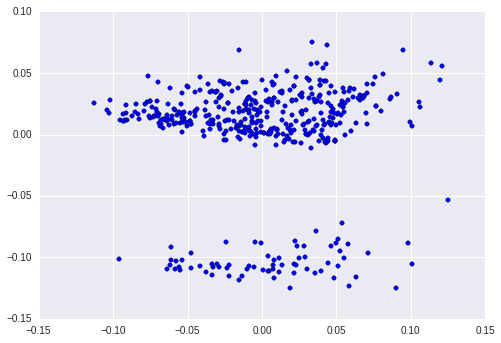

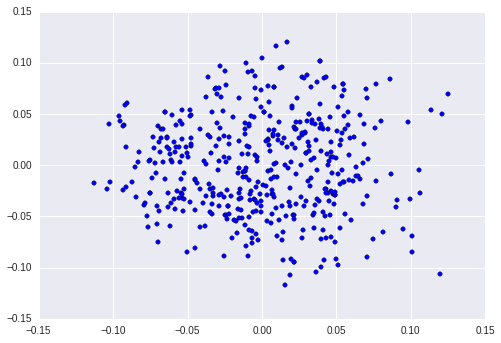

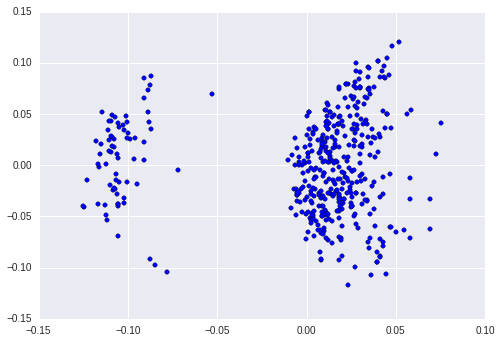

In [53]:
X__ = sklearn.decomposition.FastICA(n_components=3).fit_transform(uXPV)

plt.scatter(X__[:,0], X__[:,1], marker='o')
plt.show()
plt.scatter(X__[:,0], X__[:,2], marker='o')
plt.show()
plt.scatter(X__[:,1], X__[:,2], marker='o')
plt.show()

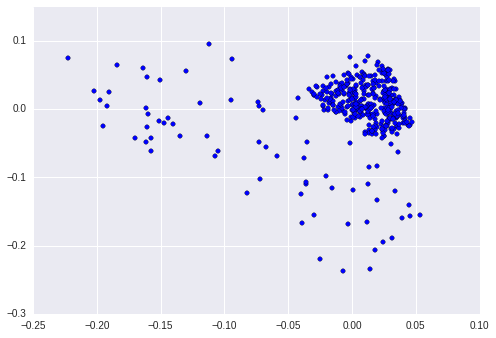

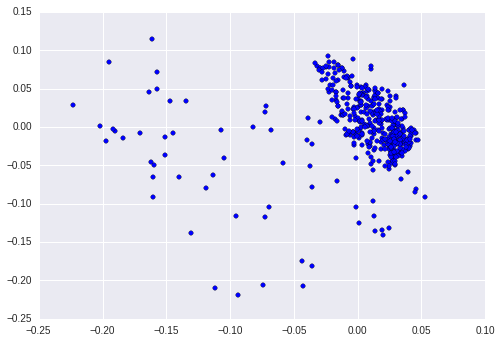

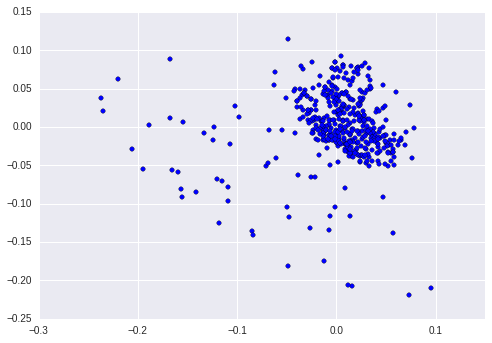

In [55]:
X__ = sklearn.decomposition.FastICA(n_components=3).fit_transform(uXPV2)

plt.scatter(X__[:,0], X__[:,1], marker='o')
plt.show()
plt.scatter(X__[:,0], X__[:,2], marker='o')
plt.show()
plt.scatter(X__[:,1], X__[:,2], marker='o')
plt.show()

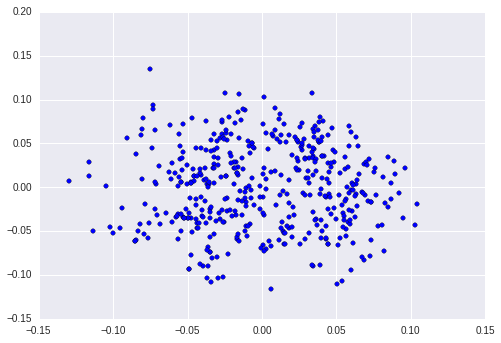

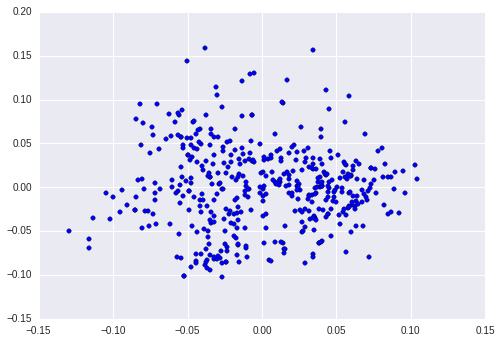

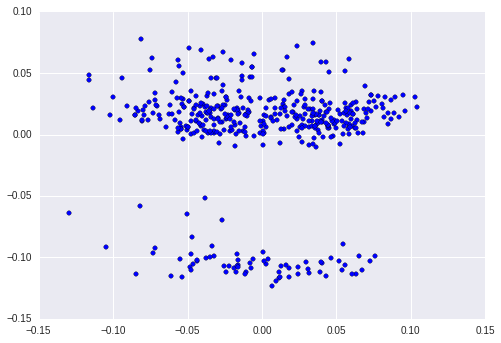

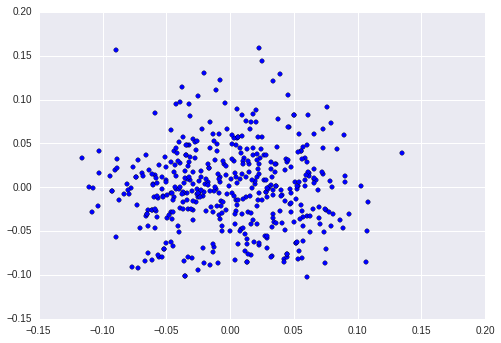

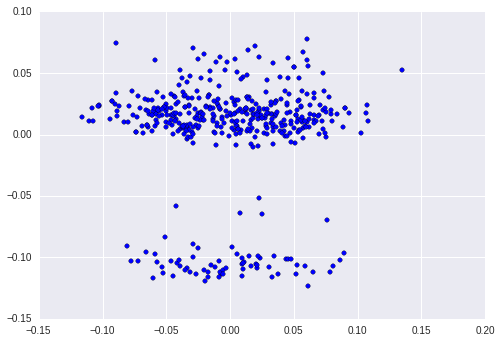

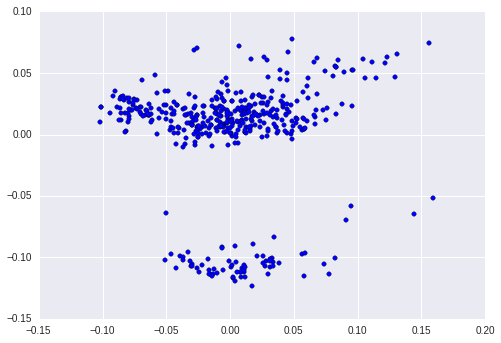

In [59]:
X__ = sklearn.decomposition.FastICA(n_components=4).fit_transform(uXPV)

plt.scatter(X__[:,0], X__[:,1], marker='o')
plt.show()
plt.scatter(X__[:,0], X__[:,2], marker='o')
plt.show()
plt.scatter(X__[:,0], X__[:,3], marker='o')
plt.show()
plt.scatter(X__[:,1], X__[:,2], marker='o')
plt.show()
plt.scatter(X__[:,1], X__[:,3], marker='o')
plt.show()
plt.scatter(X__[:,2], X__[:,3], marker='o')
plt.show()

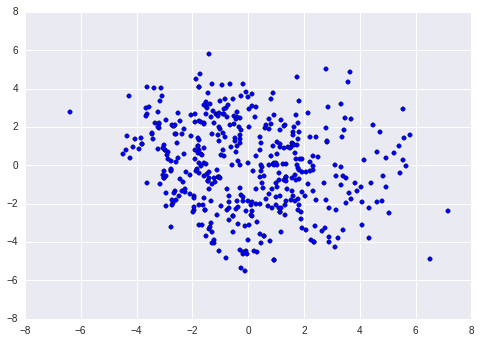

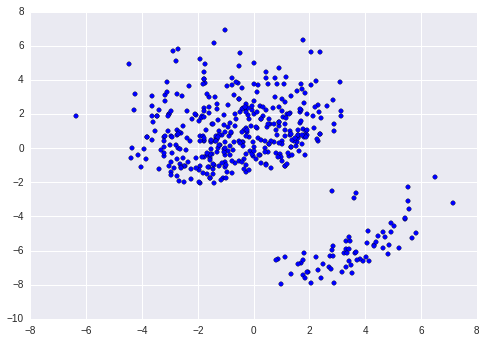

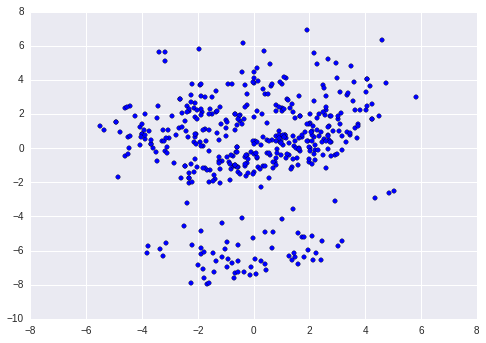

In [58]:
X__ = sklearn.manifold.MDS(n_components=3).fit_transform(uXPV)

plt.scatter(X__[:,0], X__[:,1], marker='o')
plt.show()
plt.scatter(X__[:,0], X__[:,2], marker='o')
plt.show()
plt.scatter(X__[:,1], X__[:,2], marker='o')
plt.show()

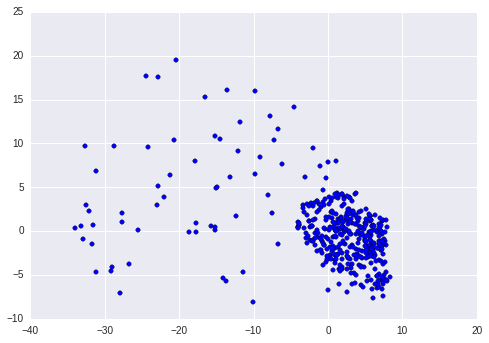

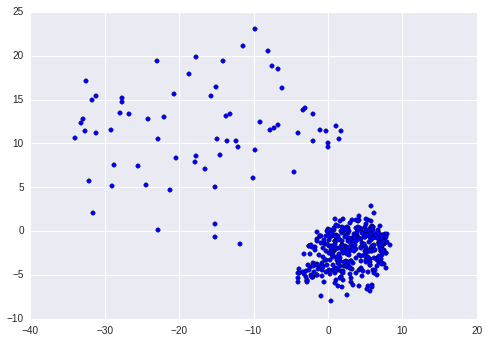

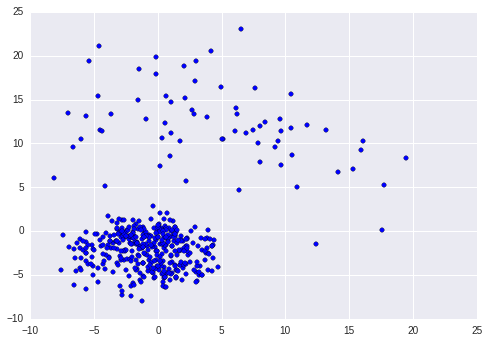

In [60]:
X__ = sklearn.manifold.MDS(n_components=3).fit_transform(uXPV2)

plt.scatter(X__[:,0], X__[:,1], marker='o')
plt.show()
plt.scatter(X__[:,0], X__[:,2], marker='o')
plt.show()
plt.scatter(X__[:,1], X__[:,2], marker='o')
plt.show()

In [33]:
# ICA on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PVcols_ = ['PV_ICA_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

['PV_ICA_0', 'PV_ICA_1', 'PV_ICA_2', 'PV_ICA_3', 'PV_ICA_4', 'PV_ICA_5', 'PV_ICA_6', 'PV_ICA_7', 'PV_ICA_8', 'PV_ICA_9', 'PV_ICA_10', 'PV_ICA_11', 'PV_ICA_12', 'PV_ICA_13', 'PV_ICA_14', 'PV_ICA_15', 'PV_ICA_16', 'PV_ICA_17', 'PV_ICA_18', 'PV_ICA_19', 'Age', 'isBig', 'isIstanbul', 'isAnkara', 'isIzmir', 'isIL', 'missingSource']
	Scored 2511658.13 with PV_ICA_0
	Scored 2511212.17 with PV_ICA_1
	Scored 2511770.57 with PV_ICA_2
	Scored 2511670.96 with PV_ICA_3
	Scored 2511780.36 with PV_ICA_4
	Scored 2511728.39 with PV_ICA_5
	Scored 2511595.90 with PV_ICA_6
	Scored 2511161.69 with PV_ICA_7
	Scored 2511749.73 with PV_ICA_8
	Scored 2511762.32 with PV_ICA_9
	Scored 2511143.87 with PV_ICA_10
	Scored 2511667.21 with PV_ICA_11
	Scored 2511616.82 with PV_ICA_12
	Scored 2511591.34 with PV_ICA_13
	Scored 2511692.45 with PV_ICA_14
	Scored 2511725.35 with PV_ICA_15
	Scored 2511709.79 with PV_ICA_16
	Scored 2511688.74 with PV_ICA_17
	Scored 2511551.14 with PV_ICA_18
	Scored 2511522.90 with PV_ICA_19
	

/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


In [ ]:
# ICA on all-samples valid-columns. Fit to unlabelled.

XPV_ = sklearn.decomposition.FastICA(random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
PVcols_ = ['PV_ICA_'+str(i) for i in range(XPV_.shape[1])]

X_ = np.concatenate((XPV_, XG, XO), axis=1)
cols_ = PVcols_ + Gcols + Ocols

print(cols_)

clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, X, y, n_folds=10, n_samp=25):
print(mu)

clf = sklearn.linear_model.ElasticNet()
support, ranking = rfa(clf, X_, y, col_names=cols_)

## break

In [32]:
np.sort(y)

array([  1149870.        ,   1270499.        ,   1619683.        ,
         1721420.99984276,   1734634.        ,   1756069.        ,
         1763231.        ,   1847826.        ,   1882131.        ,
         1904842.        ,   1999097.        ,   2005018.99951519,
         2018785.        ,   2021934.        ,   2025297.        ,
         2055379.        ,   2058644.        ,   2083447.        ,
         2097022.        ,   2156098.        ,   2267425.        ,
         2302088.99951048,   2344689.        ,   2364478.        ,
         2371202.        ,   2383840.        ,   2390534.        ,
         2525375.        ,   2544857.        ,   2551252.        ,
         2594465.99961865,   2595102.99944952,   2675511.        ,
         2732645.        ,   2738052.        ,   2740687.        ,
         2792031.        ,   2843304.99900058,   2884765.9989553 ,
         2954086.        ,   2993069.        ,   2999068.        ,
         3004429.        ,   3008199.        ,   3009374.00007

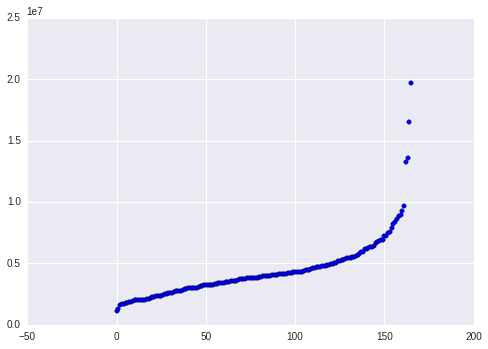

In [34]:
plt.scatter(np.arange(len(y)),np.sort(y))

In [35]:
XPV_ = sklearn.decomposition.FastICA(n_components=3, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356337.51807


In [35]:
XPV_ = sklearn.decomposition.FastICA(n_components=3, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356337.51807


In [57]:
cv = StratifiedPercentileKFold.StratifiedPercentileKFold(y, n_folds=10, shuffle=True, random_state=3, shuffle_windows=True)

scaler = scalers.BoxCoxScaler(standardise=True)

scaler.fit(np.log(np.expand_dims(y,1)))
y_transform_fn = lambda x: np.exp(scaler.inverse_transform(np.expand_dims(x,1)))

y_ = np.squeeze(scaler.transform(np.log(np.expand_dims(y,1))))

clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y_, n_folds=10, n_samp=25, start_seed=3000, y_transform=y_transform_fn)
print(mu)

2575025.88589


In [104]:
from sklearn.base import BaseEstimator, TransformerMixin

class outlier_threshold(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, minthreshold=None, maxthreshold=None, mode='remove'):
        self.base_classifier = base_classifier
        self.minthreshold = minthreshold
        self.maxthreshold = maxthreshold
        self.mode = mode
        
    def threshold(self, X, y):
        if y is None:
            return X,y
        y = np.array(y)
        
        if self.mode=='remove':
            li = np.ones(y.shape, dtype=bool)
            if self.minthreshold is not None:
                li = li * (y > self.minthreshold)
            if self.maxthreshold is not None:
                li = li * (y < self.maxthreshold)
            return X[li], y[li]
        elif self.mode=='cap':
            if self.minthreshold is not None:
                y[y < self.minthreshold] = self.minthreshold
            if self.maxthreshold is not None:
                y[y > self.maxthreshold] = self.maxthreshold
            return X, y
        else:
            raise NotImplementedError
    
    def fit(self, X, y):
        X,y = self.threshold(X, y)
        return self.base_classifier.fit(X, y)
    
    def predict(self, X):
        return self.base_classifier.predict(X)
    
    def transform(self, X, y=None):
        X, y = self.threshold(X, y)
        return self.base_classifier.transform(X, y)

In [68]:
clf = sklearn.linear_model.ElasticNet()
#clf = outlier_threshold(clf, maxthreshold=10000000)

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356337.51807


In [102]:
clf = sklearn.linear_model.ElasticNet()
clf = outlier_threshold(clf, maxthreshold=10000000)

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2397573.86015


In [105]:
clf = sklearn.linear_model.ElasticNet()
clf = outlier_threshold(clf, maxthreshold=10000000, mode='cap')

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2372918.06813


In [103]:
clf = sklearn.linear_model.ElasticNet()
clf = outlier_threshold(clf, minthreshold=1500000, maxthreshold=10000000)

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2398948.79094


In [106]:
clf = sklearn.linear_model.ElasticNet()
clf = outlier_threshold(clf, minthreshold=1500000, maxthreshold=10000000, mode='cap')

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2373163.81159


In [114]:
import scipy.stats.mstats

In [111]:
class CustomBagger(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, n_folds=10, n_samp=25, start_seed=4000, mode='mean'):
        self.base_classifier = base_classifier
        self.n_folds = n_folds
        self.n_samp = n_samp
        self.start_seed = start_seed
        self.mode = mode
        
    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self
    
    def predict(self, X_test):
        
        predictions = np.zeros((self.n_folds, self.n_samp, X_test.shape[0]))
        
        for seed in range(self.n_samp):
            cv = StratifiedPercentileKFold.StratifiedPercentileKFold(self.y_,
                                                                     n_folds=self.n_folds,
                                                                     shuffle=True,
                                                                     random_state=self.start_seed+seed,
                                                                     shuffle_windows=True)
            for i, (train, _) in enumerate(cv):
                clf = self.base_classifier
                clf.fit(self.X_[train], self.y_[train])
                y_k = clf.predict(X_test)
                predictions[i,seed,:] = y_k
                
        predictions = np.reshape(predictions, (self.n_folds*self.n_samp, X_test.shape[0]))
        if self.mode=='mean':
            y_pred = np.mean(predictions, axis=0)
        elif self.mode=='geomean':
            y_pred = scipy.stats.mstats.gmean(predictions, axis=0)
        elif self.mode=='median':
            y_pred = np.median(predictions, axis=0)
        else:
            raise NotImplementedError
            
        return y_pred

In [112]:
clf = sklearn.linear_model.ElasticNet()
clf = CustomBagger(clf, mode='mean')

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356329.46737


In [115]:
clf = sklearn.linear_model.ElasticNet()
clf = CustomBagger(clf, mode='median')

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356075.09443


In [116]:
clf = sklearn.linear_model.ElasticNet()
clf = CustomBagger(clf, mode='geomean')

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356327.31741


In [117]:
clf = sklearn.linear_model.ElasticNet()

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2356337.51807


In [118]:
clf = sklearn.linear_model.Lasso()

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2342120.9325


In [119]:
clf = sklearn.linear_model.LinearRegression()

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2342123.27781


In [120]:
clf = sklearn.linear_model.Ridge()

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2324077.02613


In [121]:
clf = sklearn.svm.SVR()

mu, std = get_cv_results(clf, np.concatenate((XPV_, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2555418.62783


In [123]:
n_components = 1
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.LinearRegression()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2336769.60901


In [124]:
n_components = 2
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.LinearRegression()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2332306.41108


In [126]:
n_components = 3
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.LinearRegression()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2342123.27781


In [125]:
n_components = 4
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.LinearRegression()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2348261.09766


In [127]:
n_components = 5
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.LinearRegression()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2360268.16595


In [128]:
n_components = 1
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2336767.64022


In [129]:
n_components = 2
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2332305.20681


In [130]:
n_components = 3
XPV_2 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2342120.9325


In [133]:
n_components = 1
XPV_2 = sklearn.decomposition.PCA(n_components=n_components).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2336769.56303


In [134]:
n_components = 2
XPV_2 = sklearn.decomposition.PCA(n_components=n_components).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2332306.38071


In [135]:
n_components = 3
XPV_2 = sklearn.decomposition.PCA(n_components=n_components).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2342123.21886


In [138]:
n_components = 1
XPV_2 = sklearn.manifold.LocallyLinearEmbedding(n_components=n_components, n_neighbors=8, random_state=889).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2335013.29809


In [139]:
n_components = 2
XPV_2 = sklearn.manifold.LocallyLinearEmbedding(n_components=n_components, n_neighbors=8, random_state=889).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2354562.65731


In [140]:
n_components = 3
XPV_2 = sklearn.manifold.LocallyLinearEmbedding(n_components=n_components, n_neighbors=8, random_state=889).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2361980.63227


In [142]:
n_components = 1
smin = uXPV.min()
XPV_2 = sklearn.decomposition.NMF(n_components=n_components).fit(uXPV - smin).transform(XPV - smin)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2336978.04027


In [144]:
n_components = 2
smin = uXPV.min()
XPV_2 = sklearn.decomposition.NMF(n_components=n_components, max_iter=1000).fit(uXPV - smin).transform(XPV - smin)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2332793.06168


In [145]:
n_components = 3
smin = uXPV.min()
XPV_2 = sklearn.decomposition.NMF(n_components=n_components, max_iter=1000).fit(uXPV - smin).transform(XPV - smin)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2343200.55307


In [146]:
n_components = 1
XPV_2 = sklearn.manifold.MDS(n_components=n_components, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2327601.52007


In [147]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=n_components, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2329251.87747


In [148]:
n_components = 3
XPV_2 = sklearn.manifold.MDS(n_components=n_components, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2346725.25478


In [149]:
n_components = 1
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2336685.37645


In [150]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2336329.59455


In [152]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.ElasticNet()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2348367.39451


In [151]:
n_components = 3
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1), y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2346792.45121


In [153]:
class ModelMerger(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, cols_1, cols_2):
        self.base_classifier = base_classifier
        self.cols_1 = cols_1
        self.cols_2 = cols_2
        
    def fit(self, X, y):
        self.clf1 = self.base_classifier.fit(X[:,self.cols_1], y)
        self.clf2 = self.base_classifier.fit(X[:,self.cols_2], y)
        return self
    
    def predict(self, X):
        yp1 = self.clf1.predict(X[:,self.cols_1])
        yp2 = self.clf2.predict(X[:,self.cols_2])
        return (yp1+yp2)/2

In [175]:
import copy

In [176]:
class ModelMerger(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, cols_list, mode='mean'):
        self.base_classifier = base_classifier
        self.cols_list = cols_list
        self.mode = mode
        
    def fit(self, X, y):
        self.clf_list = []
        for cols in self.cols_list:
            clf = copy.deepcopy(self.base_classifier)
            self.clf_list.append(clf.fit(X[:,cols], y))
        return self
    
    def predict(self, X):
        yp = np.zeros((len(self.cols_list), X.shape[0]))
        for i,cols in enumerate(self.cols_list):
            yp[i,:] = self.clf_list[i].predict(X[:,cols])
        
        if self.mode=='mean':
            yp = np.mean(yp, axis=0)
        elif self.mode=='geomean':
            yp = scipy.stats.mstats.gmean(yp, axis=0)
        elif self.mode=='median':
            yp = np.median(yp, axis=0)
        else:
            raise NotImplementedError
            
        return yp

In [177]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

X_ = np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1)

li1 = np.ones((X_.shape[1]),dtype=bool)
li1[1:3] = False
li2 = np.ones((X_.shape[1]),dtype=bool)
li2[0] = False

clf = sklearn.linear_model.Lasso()
clf = ModelMerger(clf, [li1, li2], 'mean')

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2321457.5498


In [178]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

X_ = np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1)

li1 = np.ones((X_.shape[1]),dtype=bool)
li1[1:3] = False
li2 = np.ones((X_.shape[1]),dtype=bool)
li2[0] = False

clf = sklearn.linear_model.Lasso()
clf = ModelMerger(clf, [li1, li2], 'geomean')

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2321229.82996


In [179]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

X_ = np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1)

li1 = np.ones((X_.shape[1]),dtype=bool)
li1[1:3] = False
li2 = np.ones((X_.shape[1]),dtype=bool)
li2[0] = False

clf = sklearn.linear_model.Lasso()
clf = ModelMerger(clf, [li1, li2], 'median')

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2321457.5498


In [184]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
XPV_4 = sklearn.decomposition.PCA(n_components=n_components).fit(uXPV).transform(XPV)

X_ = np.concatenate((XPV_2, XPV_3, XPV_4, XG, XO[:,[0]]), axis=1)

li1 = np.ones((X_.shape[1]),dtype=bool)
li1[1:5] = False
li2 = np.ones((X_.shape[1]),dtype=bool)
li2[0] = False
li2[3:5] = False
li3 = np.ones((X_.shape[1]),dtype=bool)
li3[0:3] = False

clf = sklearn.linear_model.Lasso()
clf = ModelMerger(clf, [li1, li2, li3], 'geomean')

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2323015.34729


In [185]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)
smin = uXPV.min()
XPV_4 = sklearn.decomposition.NMF(n_components=n_components, max_iter=1000).fit(uXPV - smin).transform(XPV - smin)

X_ = np.concatenate((XPV_2, XPV_3, XPV_4, XG, XO[:,[0]]), axis=1)

li1 = np.ones((X_.shape[1]),dtype=bool)
li1[1:5] = False
li2 = np.ones((X_.shape[1]),dtype=bool)
li2[0] = False
li2[3:5] = False
li3 = np.ones((X_.shape[1]),dtype=bool)
li3[0:3] = False

clf = sklearn.linear_model.Lasso()
clf = ModelMerger(clf, [li1, li2, li3], 'geomean')

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2323193.95605


In [183]:
li3

array([False, False, False,  True,  True,  True,  True], dtype=bool)

In [171]:
X_ = np.concatenate((XG, XO[:,[0]]), axis=1)

clf = sklearn.linear_model.Lasso()

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2328156.11209


In [174]:
li2

array([False,  True,  True,  True,  True], dtype=bool)

In [186]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

X_ = np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1)

li1 = np.ones((X_.shape[1]),dtype=bool)
li1[1:3] = False
li2 = np.ones((X_.shape[1]),dtype=bool)
li2[0] = False

clf = sklearn.linear_model.Lasso()
clf = ModelMerger(clf, [li1, li2], 'geomean')
clf = CustomBagger(clf, mode='mean')

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2321287.06426


In [187]:
n_components = 2
XPV_2 = sklearn.manifold.MDS(n_components=1, random_state=888).fit_transform(uXPV)[index_is_labelled,:]
XPV_3 = sklearn.decomposition.FastICA(n_components=n_components, random_state=889, max_iter=10000, tol=0.000001).fit(uXPV).transform(XPV)

X_ = np.concatenate((XPV_2, XPV_3, XG, XO[:,[0]]), axis=1)

li1 = np.ones((X_.shape[1]),dtype=bool)
li1[1:3] = False
li2 = np.ones((X_.shape[1]),dtype=bool)
li2[0] = False

clf = sklearn.linear_model.Lasso()
clf = CustomBagger(clf, mode='mean')
clf = ModelMerger(clf, [li1, li2], 'geomean')

mu, std = get_cv_results(clf, X_, y, n_folds=10, n_samp=25, start_seed=3000)
print(mu)

2321286.58827


## BREAK

In [202]:
X_list = []
cols_ = []

X_list.append(XG[data_nomissing,:])
X_list.append(XO[data_nomissing,:])
cols_ += Gcols
cols_ += Ocols

s = sklearn.decomposition.FastICA(n_components=1, random_state=890, tol=0.000001, max_iter=100000).fit(uXPM)
XDR_ = s.transform(XPM[data_nomissing,:])

X_ = np.concatenate((XDR_, XG[data_nomissing,:], XO[data_nomissing][:,[0]]), axis=1)

clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, X_, y[data_nomissing], n_folds=10, n_samp=25, start_seed=3000)
print(mu)

1946228.82295


In [203]:
X_list = []
cols_ = []

X_list.append(XG[data_nomissing,:])
X_list.append(XO[data_nomissing,:])
cols_ += Gcols
cols_ += Ocols

s = sklearn.decomposition.FastICA(n_components=2, random_state=890, tol=0.000001, max_iter=100000).fit(uXPM)
XDR_ = s.transform(XPM[data_nomissing,:])

X_ = np.concatenate((XDR_, XG[data_nomissing,:], XO[data_nomissing][:,[0]]), axis=1)

clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, X_, y[data_nomissing], n_folds=10, n_samp=25, start_seed=3000)
print(mu)

1901339.29173


In [204]:
X_list = []
cols_ = []

X_list.append(XG[data_nomissing,:])
X_list.append(XO[data_nomissing,:])
cols_ += Gcols
cols_ += Ocols

s = sklearn.decomposition.FastICA(n_components=3, random_state=890, tol=0.000001, max_iter=100000).fit(uXPM)
XDR_ = s.transform(XPM[data_nomissing,:])

X_ = np.concatenate((XDR_, XG[data_nomissing,:], XO[data_nomissing][:,[0]]), axis=1)

clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, X_, y[data_nomissing], n_folds=10, n_samp=25, start_seed=3000)
print(mu)

1913778.05575


In [205]:
X_list = []
cols_ = []

X_list.append(XG[data_nomissing,:])
X_list.append(XO[data_nomissing,:])
cols_ += Gcols
cols_ += Ocols

s = sklearn.decomposition.FastICA(n_components=4, random_state=890, tol=0.000001, max_iter=100000).fit(uXPM)
XDR_ = s.transform(XPM[data_nomissing,:])

X_ = np.concatenate((XDR_, XG[data_nomissing,:], XO[data_nomissing][:,[0]]), axis=1)

clf = sklearn.linear_model.Lasso()
mu, std = get_cv_results(clf, X_, y[data_nomissing], n_folds=10, n_samp=25, start_seed=3000)
print(mu)

1954151.05872


/usr/local/lib/python3.4/dist-packages/sklearn/decomposition/fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')
